In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading the data and doing some exploration

In [10]:
df = pd.read_pickle('pga_stats_final.pkl')

In [3]:
df.head(10)

,player,scoring_avg,driving_dist,driving_acc,gir_fairway,gir_other,sg_tee_to_green,sg_total,sg_putting,scrambling,3_putt_avoid,putts_per_round,prox_to_hole,bogey_avoidance,earnings
0,Jordan Spieth,68.938,291.8,62.91,80.26,50.11,1.583,2.154,0.571,65.03,2.40,27.82,404.0,13.13,12030465
1,Jason Day,69.161,313.7,55.94,79.12,60.58,1.520,2.106,0.586,65.34,2.39,28.44,435.0,12.11,9403330
2,Bubba Watson,69.296,315.2,56.55,79.81,55.53,1.876,2.088,0.212,61.89,3.35,28.96,432.0,14.54,6876797
3,Rickie Fowler,70.230,296.8,62.08,76.53,48.73,0.779,1.088,0.309,61.10,2.47,28.44,421.0,15.05,5773430
4,Dustin Johnson,69.585,317.7,55.53,78.65,56.44,1.326,1.455,0.128,57.85,2.08,28.47,414.0,15.51,5509467
5,Justin Rose,69.744,303.5,63.87,81.14,54.17,1.471,1.493,0.023,59.14,3.11,29.17,401.0,14.56,5462677
7,Zach Johnson,69.753,282.6,71.21,76.86,47.88,1.081,1.120,0.040,60.98,1.98,28.78,414.0,13.86,4801487
8,Henrik Stenson,69.354,296.4,69.91,79.32,57.48,1.774,2.210,0.436,62.24,3.89,29.87,432.0,13.61,4755070
9,Jimmy Walker,70.268,301.6,52.23,79.62,51.99,0.241,0.933,0.692,57.71,3.04,28.70,436.0,16.73,4521350
10,Charley Hoffman,70.613,298.9,58.01,79.84,53.89,0.269,0.335,0.065,58.74,2.66,28.83,433.0,16.25,4041089


In [4]:
df.describe()

,scoring_avg,driving_dist,driving_acc,gir_fairway,gir_other,sg_tee_to_green,sg_total,sg_putting,scrambling,3_putt_avoid,putts_per_round,prox_to_hole,bogey_avoidance,earnings
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,7.470000e+02
mean,70.953535,293.138286,61.553253,77.018701,51.229799,0.132657,0.161747,0.029100,58.842838,2.921178,29.073548,431.369478,16.266011,1.627917e+06
std,0.700194,8.972915,5.105309,2.847482,3.831485,0.649139,0.692001,0.330853,3.267814,0.652091,0.492514,19.725191,1.751505,1.545441e+06
min,68.698000,269.700000,43.020000,65.150000,36.050000,-3.340000,-3.209000,-1.351000,44.010000,1.410000,27.710000,377.000000,12.110000,2.487800e+04
25%,70.556500,287.350000,58.010000,75.240000,48.755000,-0.253000,-0.228500,-0.176500,56.670000,2.460000,28.725000,417.000000,15.050000,6.156065e+05
50%,70.950000,292.700000,61.550000,77.150000,51.220000,0.139000,0.176000,0.042000,58.960000,2.870000,29.080000,430.000000,16.150000,1.126057e+06
75%,71.358500,298.900000,65.075000,79.125000,53.820000,0.521000,0.554500,0.238500,61.110000,3.325000,29.385000,444.000000,17.260000,2.064194e+06
max,74.262000,319.700000,76.880000,84.860000,62.300000,2.126000,2.551000,1.130000,67.980000,5.490000,30.540000,527.000000,25.430000,1.203046e+07


When looking at earnings, our range spans from around 25000 USD to 12000000 USD.

Why a golfer could make that little money would be from either:

1. Poor play
2. Not playing a lot of tournaments

I want to set a floor at $500,000 as a "reasonable" floor earnings for a professional golfer in order to hopefully make my model more generalizeable by eliminating outliers.

In [6]:
# Removing golfers with earnings less than $500,000 

df = df[df['earnings'] > 500000]


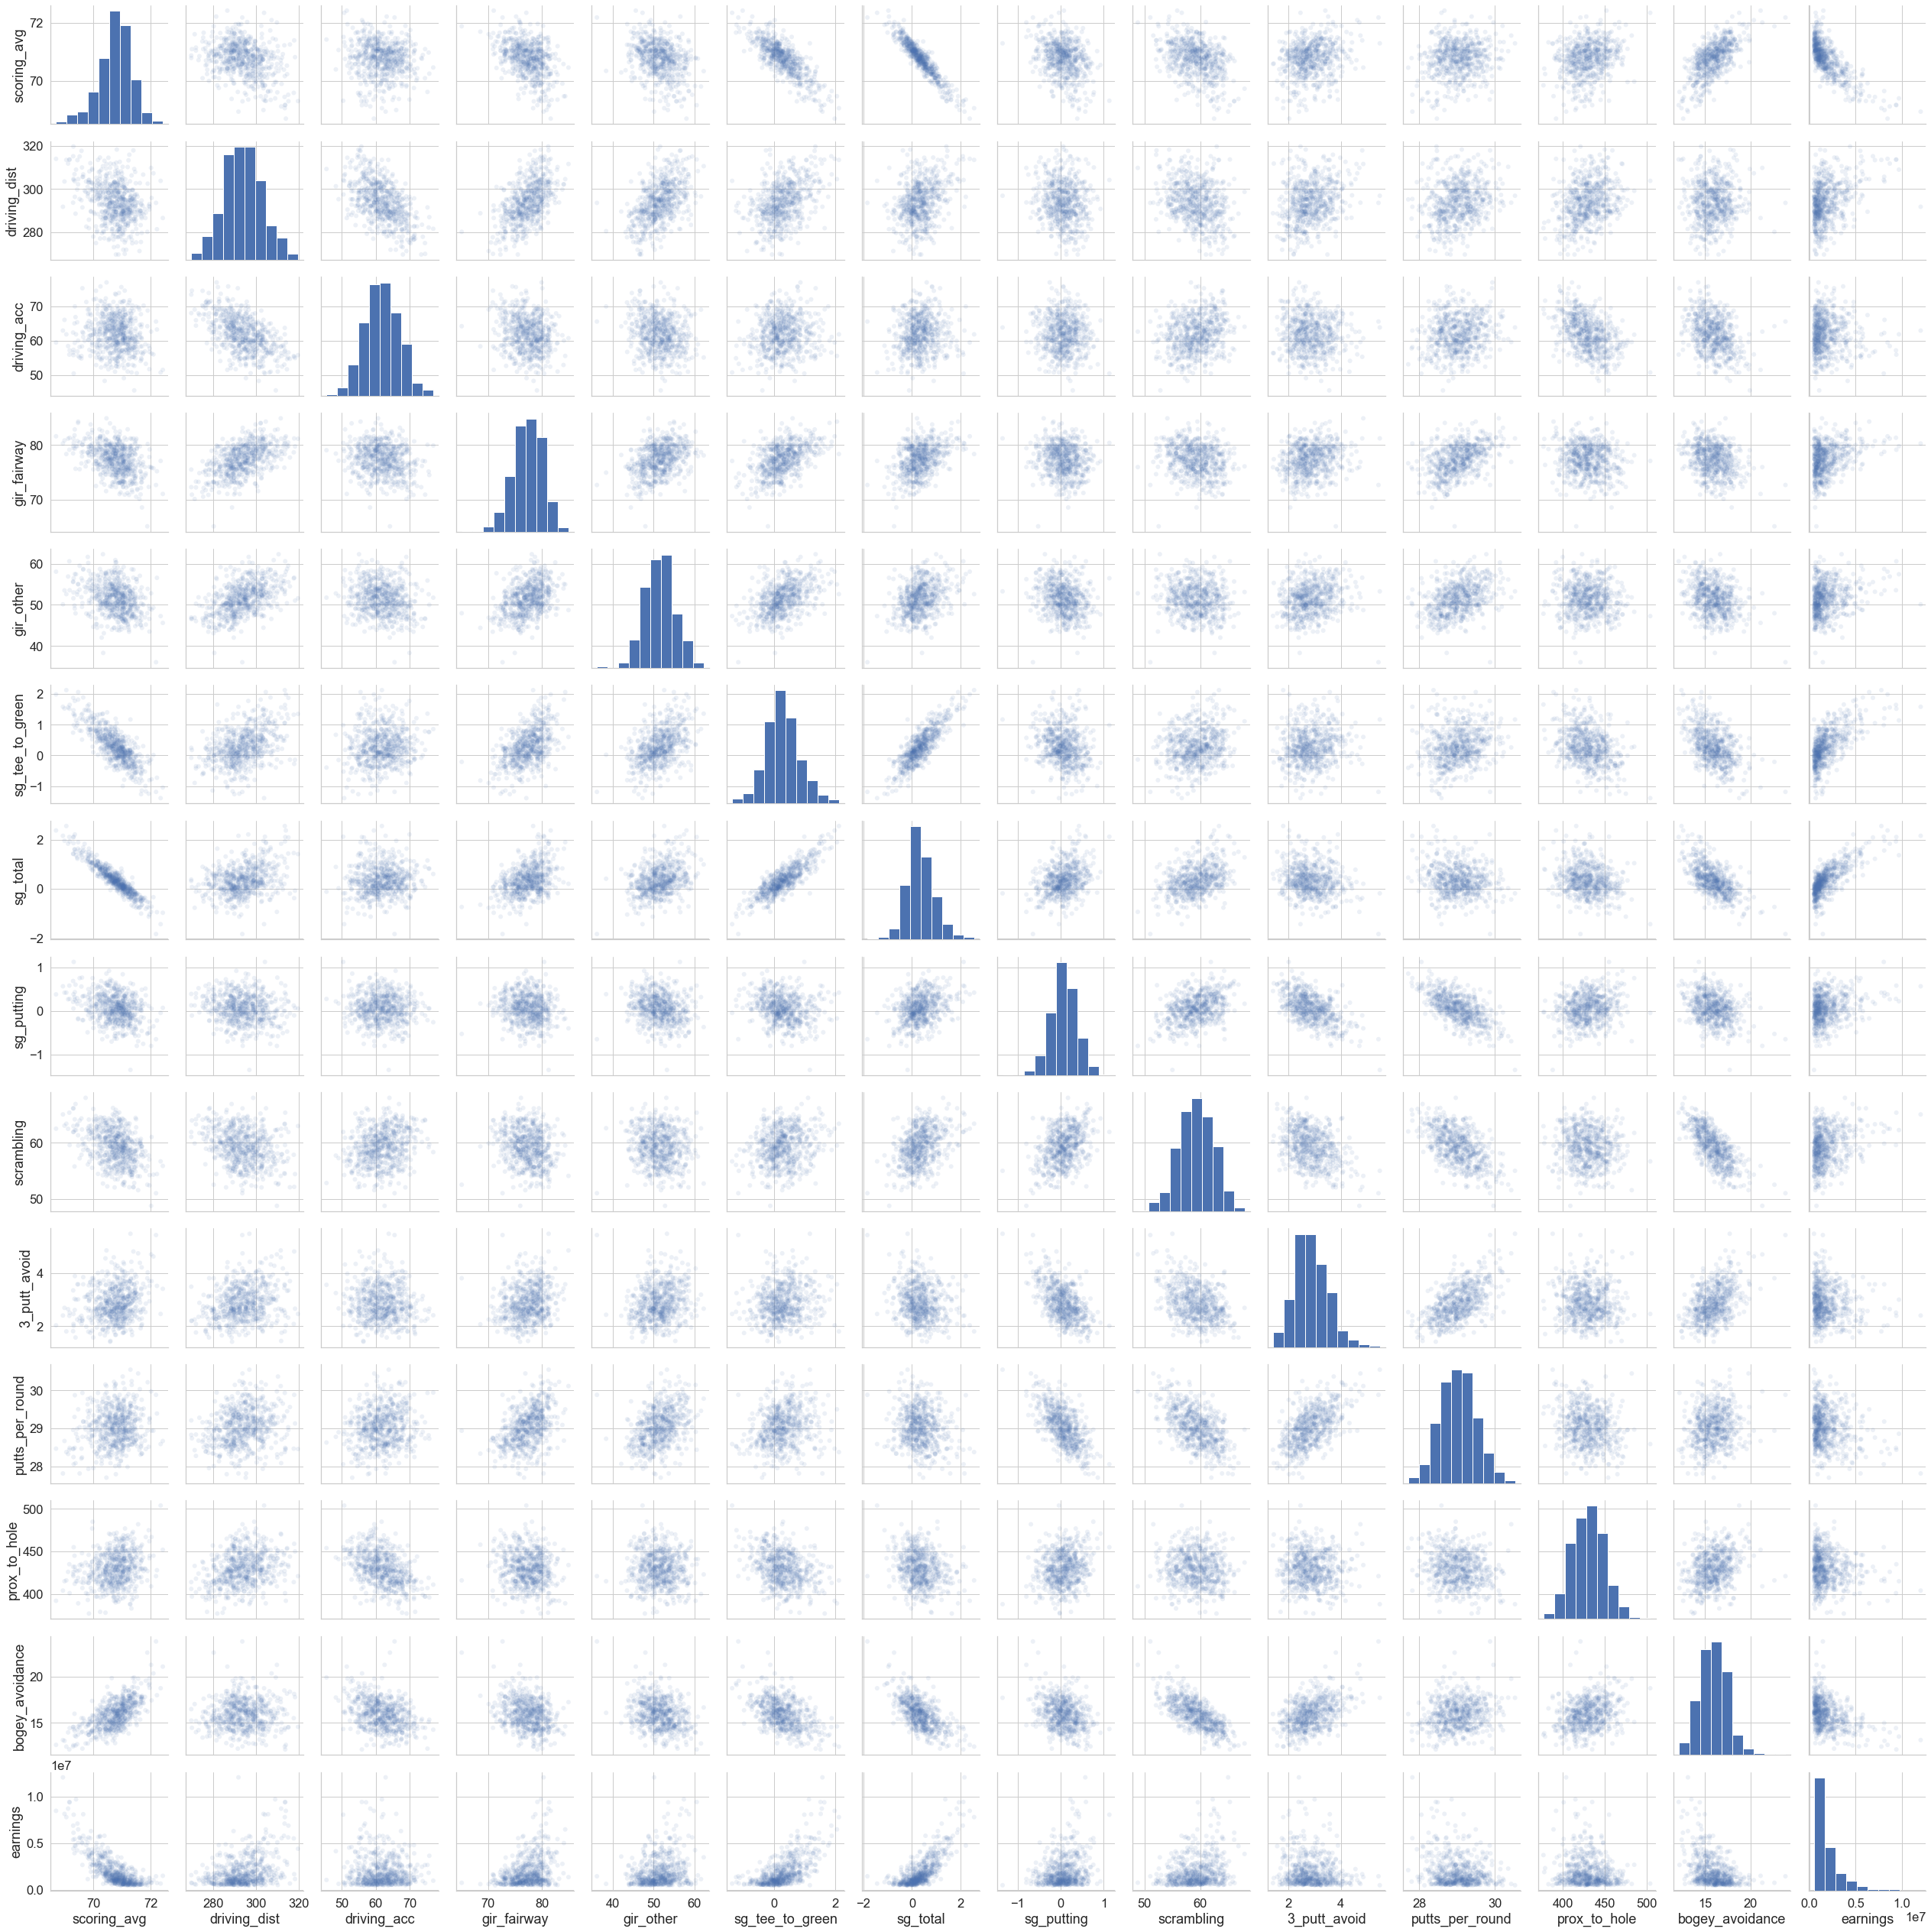

In [8]:
# Checking out a pairplot to determine an corrrelations between variables

sns.pairplot(df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [9]:
df.corr()

,scoring_avg,driving_dist,driving_acc,gir_fairway,gir_other,sg_tee_to_green,sg_total,sg_putting,scrambling,3_putt_avoid,putts_per_round,prox_to_hole,bogey_avoidance,earnings
scoring_avg,1.000000,-0.311152,-0.094733,-0.418764,-0.313155,-0.805879,-0.943620,-0.305684,-0.397374,0.212426,0.157124,0.238094,0.654660,-0.764048
driving_dist,-0.311152,1.000000,-0.543442,0.531183,0.494979,0.407017,0.320163,-0.136509,-0.283704,0.243904,0.208459,0.282514,0.043512,0.366501
driving_acc,-0.094733,-0.543442,1.000000,-0.187957,-0.179233,0.102243,0.072715,-0.048522,0.222784,-0.062743,0.146551,-0.450820,-0.347400,-0.051131
gir_fairway,-0.418764,0.531183,-0.187957,1.000000,0.391621,0.495694,0.414375,-0.120753,-0.189729,0.186454,0.431332,-0.121363,-0.304437,0.328960
gir_other,-0.313155,0.494979,-0.179233,0.391621,1.000000,0.462006,0.341000,-0.196524,-0.098252,0.180395,0.378019,-0.048793,-0.295596,0.220233
sg_tee_to_green,-0.805879,0.407017,0.102243,0.495694,0.462006,1.000000,0.850934,-0.215509,0.192722,0.116706,0.200295,-0.340982,-0.499051,0.646349
sg_total,-0.943620,0.320163,0.072715,0.414375,0.341000,0.850934,1.000000,0.329545,0.394610,-0.188115,-0.156446,-0.224832,-0.646569,0.749566
sg_putting,-0.305684,-0.136509,-0.048522,-0.120753,-0.196524,-0.215509,0.329545,1.000000,0.387280,-0.559505,-0.650876,0.194882,-0.305018,0.231653
scrambling,-0.397374,-0.283704,0.222784,-0.189729,-0.098252,0.192722,0.394610,0.387280,1.000000,-0.394128,-0.569594,-0.071125,-0.725265,0.251909
3_putt_avoid,0.212426,0.243904,-0.062743,0.186454,0.180395,0.116706,-0.188115,-0.559505,-0.394128,1.000000,0.578056,-0.056091,0.458254,-0.122335


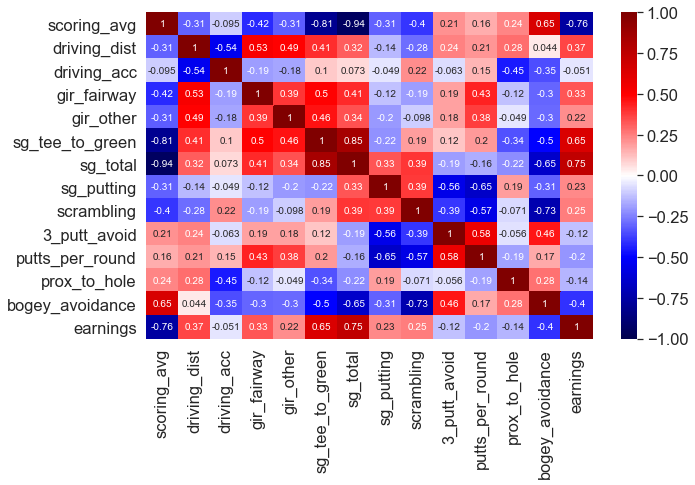

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='seismic', annot=True)

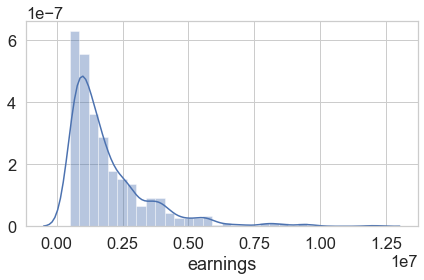

In [259]:
sns.distplot(df['earnings'])
plt.tight_layout();
#plt.savefig('earnings.png', dpi=200)

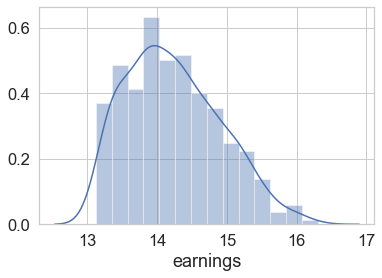

In [27]:
sns.distplot(np.log(df['earnings']));

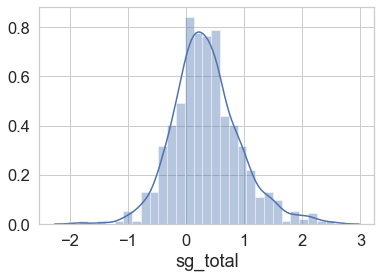

In [34]:
sns.distplot(df['sg_total']);

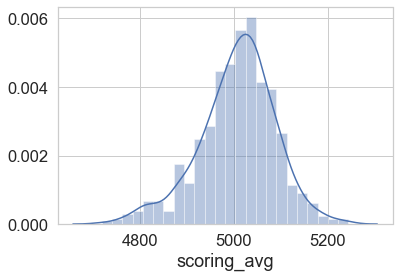

In [39]:
sns.distplot(df['scoring_avg'].pow(2));

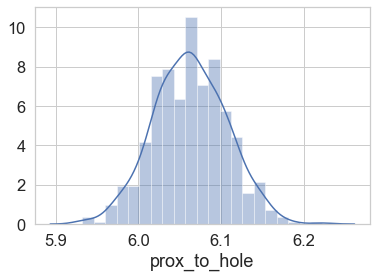

In [48]:
sns.distplot(np.log(df['prox_to_hole']));

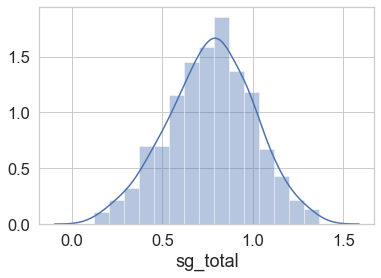

In [54]:
sns.distplot((df['sg_total'].pow(1/3)));

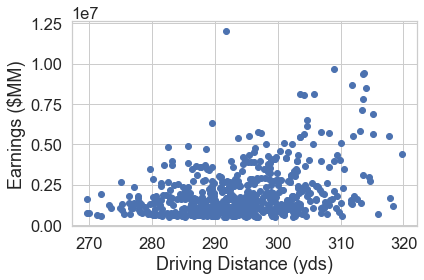

In [261]:
plt.scatter(df['driving_dist'], df['earnings']) 
plt.xlabel("Driving Distance (yds)") 
plt.ylabel("Earnings ($MM)")
plt.tight_layout()

#plt.savefig("driving_distance.png", dpi=200) 
  
plt.show();

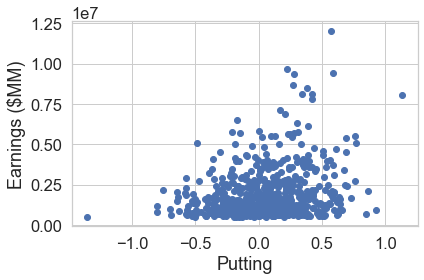

In [253]:
plt.scatter(df['sg_putting'], df['earnings']) 
plt.xlabel("Putting") 
plt.ylabel("Earnings ($MM)")
plt.tight_layout()

#plt.savefig("putting.png", pad_inches=0.1) 
  
plt.show();

### Establishing a baseline model

For my baseline model, I will be starting with simple Linear Regression using all of my features except for the player's name in order to predict earnings.

In [11]:
# Split features and outcomes
X_df, y_df = df.drop(['player', 'earnings'], axis=1), df['earnings']

# Reserve 20% of the data as our final test set
X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=.2) 

X_arr, y_arr = np.array(X), np.array(y)

In [12]:
kf = KFold(n_splits=5, shuffle=True)

In [20]:
# Baseline model on simple linear regression
cv_lm_r2s_train = []
cv_lm_r2s = []     

for train_idx, val_idx in kf.split(X_arr, y_arr):
    
    X_train, y_train = X_arr[train_idx], y_arr[train_idx]
    X_val, y_val = X_arr[val_idx], y_arr[val_idx] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s_train.append(lm.score(X_train, y_train))
    cv_lm_r2s.append(lm.score(X_val, y_val))

print('Train Regression scores: ', cv_lm_r2s_train)
print(f'Mean train cv r^2: {np.mean(cv_lm_r2s_train):.3f} +- {np.std(cv_lm_r2s_train):.3f}')
print('-----')
print('Val Regression scores: ', cv_lm_r2s)
print(f'Mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

Train Regression scores:  [0.6386579879783524, 0.6301537502622232, 0.6469051254476845, 0.6378625354745291, 0.6428293617084785]
Mean train cv r^2: 0.639 +- 0.006
-----
Val Regression scores:  [0.585251663455354, 0.6301358030761064, 0.5653361931073351, 0.6009892772866439, 0.5944735830565768]
Mean cv r^2: 0.595 +- 0.021


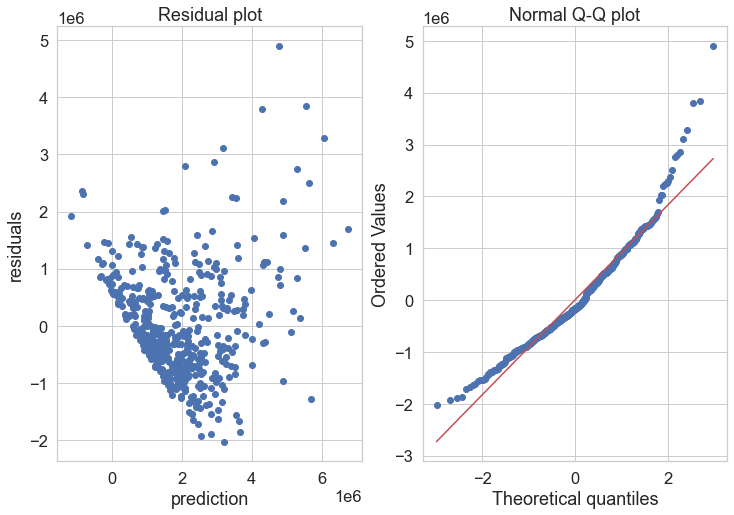

In [22]:
import scipy.stats as stats

plt.figure(figsize=(12,8))
rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)
res = y - pred

# Plotting the residuals
plt.subplot(1, 2, 1)
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 2, 2)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");


Since I saw a very right skewed distribution of earnings, I'm going to try a log transformation on my target variable of earnings to see if this helps with the model's accuracy.

In addition, I am going to log trarnsform some of my features potentially had non-linear releationships with the target outcome.

In [55]:
X2 = X.copy()
X2['scoring_avg_sq'] = X2['scoring_avg'].pow(2)
X2['3_putt_avoid_log'] = np.log(X2['3_putt_avoid'])
X2['prox_to_hole_log'] = np.log(X2['prox_to_hole'])

y2 = y.copy()
y2 = np.log(y2)

In [58]:
X2_arr = np.array(X2)
y2_arr = np.array(y2)

In [59]:
# Feature engineering to baseline linear regression

cv_lmf_r2s_train = []
cv_lmf_r2s = []    

for train_idx, val_idx in kf.split(X2_arr, y2_arr):
    
    X_train, y_train = X2_arr[train_idx], y2_arr[train_idx]
    X_val, y_val = X2_arr[val_idx], y2_arr[val_idx] 
    
    lmf = LinearRegression()

    lmf.fit(X_train, y_train)
    cv_lmf_r2s_train.append(lmf.score(X_train, y_train))
    cv_lmf_r2s.append(lmf.score(X_val, y_val))
    

print('Train Regression scores: ', cv_lmf_r2s_train)
print(f'Mean train cv r^2: {np.mean(cv_lmf_r2s_train):.3f} +- {np.std(cv_lmf_r2s_train):.3f}')
print('-----')
print('Val Regression scores: ', cv_lmf_r2s)
print(f'Mean cv r^2: {np.mean(cv_lmf_r2s):.3f} +- {np.std(cv_lmf_r2s):.3f}')


Train Regression scores:  [0.6179817010623881, 0.6197051720041932, 0.661026130569714, 0.6478958992905726, 0.6077943948244229]
Mean train cv r^2: 0.631 +- 0.020
-----
Val Regression scores:  [0.6249445178943662, 0.6509711021526784, 0.3886232817279809, 0.48821985561215286, 0.6769844891832804]
Mean cv r^2: 0.566 +- 0.110


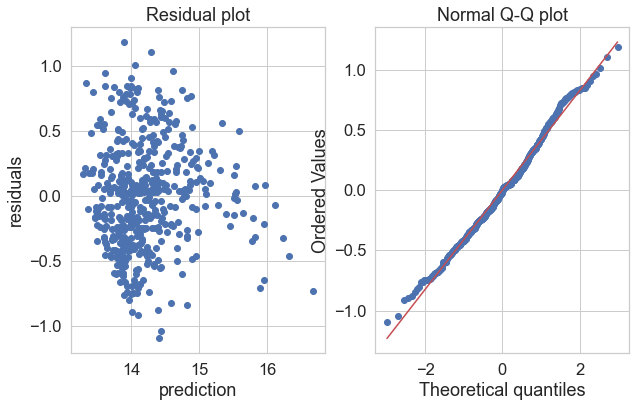

In [65]:
plt.figure(figsize=(10, 6))
rgr = LinearRegression()
rgr.fit(X2, y2)
pred = rgr.predict(X2)
res = y2 - pred

# Plotting the residuals
plt.subplot(1, 2, 1)
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 2, 2)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

Engineering features with transformations did not seem to have a noticeable effect on the model's accuracy.

Let's try adding polynomial features to the model and see how that affects the accuracy score.

In [66]:
cv_poly_r2s_train = []
cv_poly_r2s = []      

for train_idx, val_idx in kf.split(X_arr, y_arr):
    
    X_train, y_train = X_arr[train_idx], y_arr[train_idx]
    X_val, y_val = X_arr[val_idx], y_arr[val_idx] 
    
    #Polynomial regression
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()

    lm_poly.fit(X_train_poly, y_train)
    cv_poly_r2s_train.append(lm_poly.score(X_train_poly, y_train))
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))

print('Train Poly scores: ', cv_poly_r2s_train)
print(f'Mean train cv r^2: {np.mean(cv_poly_r2s_train):.3f} +- {np.std(cv_poly_r2s_train):.3f}')
print('Val Poly scores: ', cv_poly_r2s)
print(f'Mean cv r^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')

Train Poly scores:  [0.7252058984818635, 0.8108220649312933, 0.7929367864889469, 0.6637771056734169, 0.7926756278967992]
Mean train cv r^2: 0.757 +- 0.055
Val Poly scores:  [0.4980731993317681, 0.5234255110753865, 0.6847321922923291, 0.5017157611959991, 0.6710375562581592]
Mean cv r^2: 0.576 +- 0.084


Polynomial regression helped us increase our accuracy on the test set, but it did not generalize as well to the validation set. 

My next step will be to apply LASSO regularization to the polynomial regression to address some of the overfitting and determine if certain features can be dropped.

In [13]:
std = StandardScaler()
X_std = std.fit_transform(X)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)

In [14]:
alpha_vec = 10**np.linspace(-2,5,1000)

lasso_model = LassoCV(alphas = alpha_vec, cv=kf)
lasso_model.fit(X_poly, y)

LassoCV(alphas=array([1.00000000e-02, 1.01626509e-02, 1.03279473e-02, 1.04959323e-02,
       1.06666496e-02, 1.08401436e-02, 1.10164595e-02, 1.11956432e-02,
       1.13777413e-02, 1.15628013e-02, 1.17508713e-02, 1.19420003e-02,
       1.21362380e-02, 1.23336350e-02, 1.25342427e-02, 1.27381132e-02,
       1.29452998e-02, 1.31558562e-02, 1.33698374e-02, 1.35872990e-02,
       1.38082977e-02, 1.40328908e-0...
       7.35981448e+04, 7.47952252e+04, 7.60117762e+04, 7.72481145e+04,
       7.85045620e+04, 7.97814457e+04, 8.10790981e+04, 8.23978568e+04,
       8.37380654e+04, 8.51000725e+04, 8.64842328e+04, 8.78909065e+04,
       8.93204600e+04, 9.07732653e+04, 9.22497005e+04, 9.37501502e+04,
       9.52750047e+04, 9.68246612e+04, 9.83995230e+04, 1.00000000e+05]),
        cv=KFold(n_splits=5, random_state=None, shuffle=True))

In [143]:
lasso_model.alpha_

35038.42245290676

In [145]:
test_set_pred = lasso_model.predict(X_poly)
r2_score(y, test_set_pred)

0.7505098188348195

In [146]:
# Polynomial regression with LASSO regularization 

cv_pl_r2s_train = []
cv_pl_r2s = []      

for train_idx, val_idx in kf.split(X_arr, y_arr):
    
    X_train, y_train = X_arr[train_idx], y_arr[train_idx]
    X_val, y_val = X_arr[val_idx], y_arr[val_idx]
    
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    std = StandardScaler()
    X_train_std = std.fit_transform(X_train_poly)
    X_val_std = std.transform(X_val_poly)

    lm_pl = Lasso(alpha=35038)

    lm_pl.fit(X_train_std, y_train)
    cv_pl_r2s_train.append(lm_pl.score(X_train_std, y_train))
    cv_pl_r2s.append(lm_pl.score(X_val_std, y_val))

print('Train Poly scores: ', cv_pl_r2s_train)
print(f'Mean train cv r^2: {np.mean(cv_pl_r2s_train):.3f} +- {np.std(cv_pl_r2s_train):.3f}')
print('Val Poly scores: ', cv_pl_r2s)
print(f'Mean cv r^2: {np.mean(cv_pl_r2s):.3f} +- {np.std(cv_pl_r2s):.3f}')

Train Poly scores:  [0.7284374139758252, 0.7061344897646409, 0.7275100725995329, 0.7503390859912662, 0.7311556723137688]
Mean train cv r^2: 0.729 +- 0.014
Val Poly scores:  [0.7130573310485218, 0.7673846420111352, 0.7216445024027021, 0.6096287734080484, 0.7013641210628867]
Mean cv r^2: 0.703 +- 0.052


We've closed the gap of overfitting to the model even though we lost a bit of accuracy. Since we want the model to be generalizable, we'll treat this as acceptable in this case. So we will use a polynomial regression with LASSO regularization (alpha of 35038) as our final model.

### Building our final model and testing the results

In [155]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

std = StandardScaler()
X_train_std = std.fit_transform(X_train_poly)
X_test_std = std.transform(X_test_poly)

model = Lasso(alpha=35038)

model.fit(X_train_std, y)

Lasso(alpha=35038)

In [156]:
model.score(X_train_std, y)

0.7270258915006975

In [157]:
model.score(X_test_std, y_test)

0.7145306057722852

Our model performed well on the validation set with an r-squared value of 0.71. 

In [198]:
list(zip(poly.get_feature_names(input_features=X.columns), model.coef_))

[('1', 0.0),
 ('scoring_avg', -451956.040123399),
 ('driving_dist', 0.0),
 ('driving_acc', -0.0),
 ('gir_fairway', 0.0),
 ('gir_other', 0.0),
 ('sg_tee_to_green', 0.0),
 ('sg_total', 0.0),
 ('sg_putting', -0.0),
 ('scrambling', -0.0),
 ('3_putt_avoid', 0.0),
 ('putts_per_round', -0.0),
 ('prox_to_hole', -0.0),
 ('bogey_avoidance', 0.0),
 ('scoring_avg^2', -0.0),
 ('scoring_avg driving_dist', 0.0),
 ('scoring_avg driving_acc', -0.0),
 ('scoring_avg gir_fairway', 0.0),
 ('scoring_avg gir_other', -0.0),
 ('scoring_avg sg_tee_to_green', 0.0),
 ('scoring_avg sg_total', 0.0),
 ('scoring_avg sg_putting', -0.0),
 ('scoring_avg scrambling', -0.0),
 ('scoring_avg 3_putt_avoid', 0.0),
 ('scoring_avg putts_per_round', -192425.04100623858),
 ('scoring_avg prox_to_hole', -0.0),
 ('scoring_avg bogey_avoidance', 0.0),
 ('driving_dist^2', 97412.93262638402),
 ('driving_dist driving_acc', 0.0),
 ('driving_dist gir_fairway', 49176.09058208281),
 ('driving_dist gir_other', 0.0),
 ('driving_dist sg_tee_to_

In [192]:
model.coef_

array([      0.        , -451956.0401234 ,       0.        ,
            -0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,      -0.        ,
            -0.        ,       0.        ,      -0.        ,
            -0.        ,       0.        ,      -0.        ,
             0.        ,      -0.        ,       0.        ,
            -0.        ,       0.        ,       0.        ,
            -0.        ,      -0.        ,       0.        ,
       -192425.04100624,      -0.        ,       0.        ,
         97412.93262638,       0.        ,   49176.09058208,
             0.        ,  127456.83299729,       0.        ,
            -0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
            -0.        ,       0.        ,      -0.        ,
             0.        ,       0.        ,      -0.        ,
            -0.        ,      -0.        ,      -0.        ,
            -0.        ,

In [161]:
pred = model.predict(X_test_std)

In [162]:
mean_absolute_error(y_test, pred)

614834.7856317189

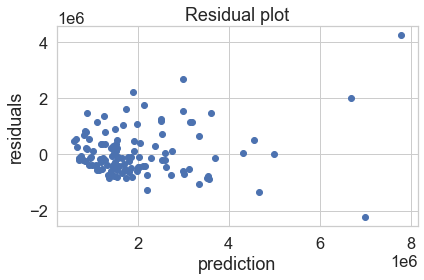

In [260]:
res = y_test - pred

plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")
plt.tight_layout()
plt.savefig('residuals.png', dpi=200)
plt.show();

In [268]:
list(zip(df['player'], pred, y_test, res))

[('Jordan Spieth', 651492.9853664173, 922707, 271214.0146335827),
 ('Jason Day', 1233621.8162687607, 1103241, -130380.81626876071),
 ('Bubba Watson', 1716825.7320674807, 1198541, -518284.7320674807),
 ('Rickie Fowler', 1452848.121019456, 1770400, 317551.87898054393),
 ('Dustin Johnson', 3571923.805096296, 2680487, -891436.8050962961),
 ('Justin Rose', 1374593.33400222, 538681, -835912.3340022201),
 ('Zach Johnson', 863487.098220858, 1648007, 784519.901779142),
 ('Henrik Stenson', 704375.1150376727, 515241, -189134.1150376727),
 ('Jimmy Walker', 1737319.8174343605, 3371705, 1634385.1825656395),
 ('Charley Hoffman', 753375.9848586689, 711609, -41766.984858668875),
 ('J.B. Holmes', 1213587.4179778213, 1594587, 380999.5820221787),
 ('Danny Lee', 2191067.3657714073, 925156, -1265911.3657714073),
 ('Robert Streb', 976922.0998306527, 887405, -89517.0998306527),
 ('Hideki Matsuyama', 3115556.178944654, 2613965, -501591.17894465383),
 ('Jim Furyk', 2601860.992991874, 2669938, 68077.007008126),


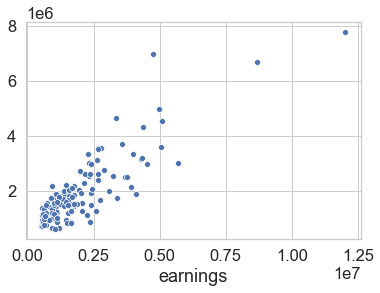

In [263]:
sns.scatterplot(y_test, pred)

To conclude, our model generalized well on the test set of data with a final r-squared of 0.71 and an MAE of around $600,000. While this is a large amount, it is not unexpected given the high degree of earnings variance as a golfer places higher and higher in tournaments. 

The features that reamined after LASSO regularization included:

- Scoring Average
- Scoring Average * Putts Per Round
- Driving Distance ** 2
- Driving Distance * Greens in Regulation from Fairway
- Driving Distaancce * Strokes Gained Tee to Green
- Strokes Gained Tee to Green * Strokes Gained Putting
- Strokes Gained Total ** 2
- Scrambling * Putts Per Round

Looking at our coefficients, the features that hint at a golfer's overall game (Scoring Average, Strokes Gained Total) are the strongest predictors of earnings, which is not unexpected. However, *Driving Distance* had a strong effect both on its own and interacting with other terms, suggesting that it is an important part of the game that can translate to increased earnings for a professional.